In [140]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch import optim

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [115]:
train_data = MNIST(
    root="/data/DataSet/",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(
            size=(32, 32)
        ),
        transforms.Normalize(
            mean=(0.5),
            std=(0.5)
        )
    ])
)
test_data = MNIST(
    root="/data/DataSet/",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(
            size=(32, 32)
        ),
        transforms.Normalize(
            mean=(0.5),
            std=(0.5)
        )
    ])
)
print(f"Training image shape: {train_data[0][0].shape}")

Training image shape: torch.Size([1, 32, 32])


In [4]:
labels_map = train_data.class_to_idx
labels_map = dict(zip(labels_map.values(), labels_map.keys()))

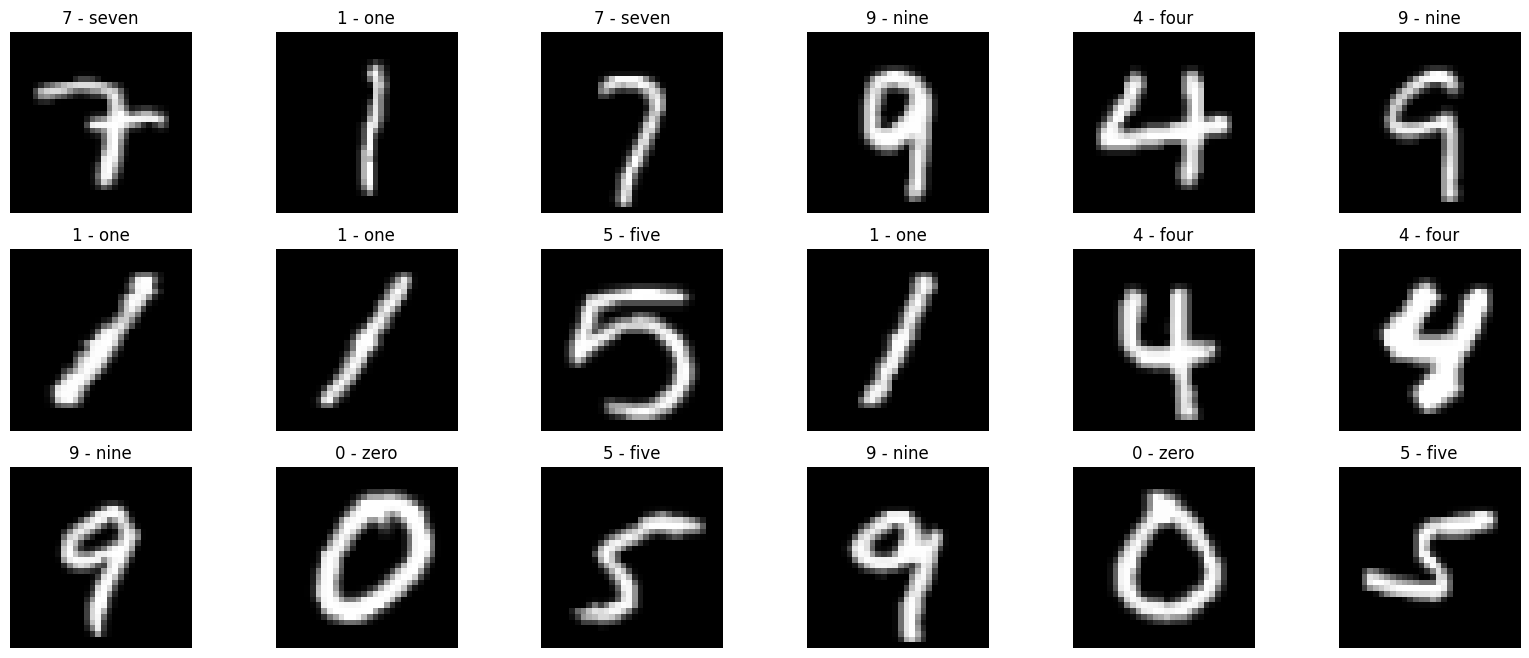

In [5]:
fig = plt.figure(figsize=(20, 8))

col = 6
row = 3

for i in range(1, col * row + 1):
    random_img_number = np.random.randint(len(train_data))
    random_img = train_data[random_img_number][0][0]

    fig.add_subplot(row, col, i)
    plt.title(labels_map[train_data[random_img_number][1]])
    plt.axis('off')
    plt.imshow(random_img, cmap='gray')

plt.show()

In [91]:
class linear(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        normalize: bool = True,
        activation: bool = True,
        dropout: float = 0.0
        ):

        super(linear, self).__init__()

        layers = [
            nn.Linear(
                in_features=in_features,
                out_features=out_features
            )
        ]

        if normalize:
            layers.append(
                nn.BatchNorm1d(
                    num_features=out_features
                )
            )
        
        if activation:
            layers.append(
                nn.ReLU()
            )

        if dropout:
            layers.append(
                nn.Dropout(
                    p=dropout
                )
            )

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    
class conv(nn.Module):
    def __init__(
        self, 
        in_channels: int, 
        out_channels: int, 
        kernel_size: int = 5, 
        stride: int = 1, 
        padding: int = 0,
        normalize: bool = True,
        activation: bool = True,
        dropout: float = 0.0
        ):

        super(conv, self).__init__()

        layers = [
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
            )
        ]
        
        if normalize:
            layers.append(
                nn.BatchNorm2d(
                    num_features=out_channels
                )
            )
        
        if activation:
            layers.append(
                nn.ReLU()
            )

        if dropout:
            layers.append(
                nn.Dropout(
                    p=dropout
                )
            )
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)
        
class LeNet(nn.Module):
    def __init__(self, in_channels: int = 1, out_channels: int = 1):
        super(LeNet, self).__init__()
        
        # 32 -> 28
        self.layer1 = conv(
            in_channels=1,
            out_channels=6
        )

        # 28 -> 14
        self.layer2 = nn.MaxPool2d(2)
        
        # 14 -> 10
        self.layer3 = conv(
            in_channels=6,
            out_channels=16
        )
        
        # 10 -> 5
        self.layer4 = nn.MaxPool2d(2)

        # 400 -> 120
        self.layer5 = linear(
            in_features=400,
            out_features=120,
        )

        # 120 -> 84
        self.layer6 = linear(
            in_features=120,
            out_features=84
        )
        
        # 84 -> 10
        self.final = nn.Sequential(
            nn.Linear(
                in_features=84,
                out_features=10
            ),
            nn.Softmax(
                dim=1
            )
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(-1, 16*5*5)
        x = self.layer5(x)
        x = self.layer6(x)
        
        return self.final(x)

In [109]:
batch_size = 516

train_loader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

dataloader_dict = {"train" : train_loader, "test": test_loader}

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f2fac0ba400>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f2fac0baa00>}


In [159]:
num_epochs = 200

model = LeNet()
model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_acc = 0.0

writer = SummaryWriter("Tensorboard/")

for epoch in tqdm(range(1, num_epochs + 1)):

    for phase in ['train', 'test']:
        if phase == "train":
            model.train()
        elif phase == "test":
            model.eval()
        
        for imgs, labels in dataloader_dict[phase]:
            x, y = imgs.to(device), labels.to(device)
 
            optimizer.zero_grad()
         
            with torch.set_grad_enabled(phase == "train"):
                y_hat = model(x)
                _, preds = torch.max(y_hat, 1)
                loss = criterion(y_hat, y)
                writer.add_scalar("Loss/train", loss, epoch)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

writer.close()

100%|██████████| 200/200 [14:50<00:00,  4.45s/it]
